<a href="https://colab.research.google.com/github/mkstt/Reference-Repo/blob/master/Lightning_demo_seed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

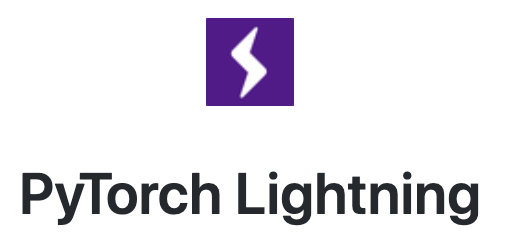

# Live DEMO

This is a minimal working example of PyTorch Lightning.

### Setup  
Lightning is easy to use. Simply ```pip install pytorch-lightning```

In [0]:
! pip install pytorch-lightning

### 1. LightningModule
Each project goes into a LightningModule.
This module houses:
1. Model definition (__init__)
2. Computations (forward)
3. What happens inside the training loop (training_step)
4. What happens inside the validation loop (validation_step)
5. What optimizer(s) to use (configure_optimizers)
6. What data to use (train_dataloader, val_dataloader, test_dataloader)

In [0]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

class MNISTModel(pl.LightningModule):

    def __init__(self):
        super(MNISTModel, self).__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor()), batch_size=32)

#### 2. Trainer
The trainer is where the magic happens!
Feed ANY LightningModule to a trainer to train the model.

In [0]:
mnist_model = MNISTModel()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(mnist_model)   

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
Validating:  63%|██████▎   | 1174/1875 [00:18<00:01, 377.73batch/s]INFO:root:  Name    Type Params
0   l1  Linear    7 K
Epoch 1: 100%|██████████| 3750/3750 [00:16<00:00, 401.02batch/s, batch_nb=1874, gpu=0, loss=0.931, v_nb=1]
                                                                   /usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer_io.py:210: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"
Epoch 10: 100%|██████████| 3750/3750 [00:18<00:00, 378.54batch/s, batch_nb=1874, gpu=0, loss=1.072, v_nb=1]
                                                                   INFO:root:Epoch 00010: early stopping
Epoch 10: 100%|██████████| 3750/3750 [00:18<00:00, 206.47batch/s, batch_nb=1874, gpu=0, loss=1.072, v_nb=1]


1

By using the trainer you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

#### Bonus
In fact, if you keep calling fit, it'll keep training the model where it left off!

In [0]:
trainer.fit(mnist_model)

#### Test set
Once you've trained using the train, val sets AND are done searching for hyperparameters, updating your model we want to run the test set!

There are 2 ways of doing that:



#### Test with current trainer
Use the same trainer you just used to test your model.

In [0]:
trainer.test()

Testing: 100%|██████████| 313/313 [00:01<00:00, 170.17batch/s]


In [0]:
trainer.tqdm_metrics

{'test_loss': 1.3869715929031372}

---
## GAN Example

How to train a GAN!

Main takeaways:
1. Generator and discriminator are arbitraty PyTorch modules.
2. training_step does both the generator and discriminator training.

## A. Generator

In [0]:
"""
To run this template just do:
python gan.py
After a few epochs, launch tensorboard to see the images being generated at every batch.
tensorboard --logdir default
"""
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import pytorch_lightning as pl


class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

## B. Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

## C. GAN

In [0]:
class GAN(pl.LightningModule):

    def __init__(self, hparams):
        super(GAN, self).__init__()
        self.hparams = hparams

        # networks
        mnist_shape = (1, 28, 28)
        self.generator = Generator(latent_dim=hparams.latent_dim, img_shape=mnist_shape)
        self.discriminator = Discriminator(img_shape=mnist_shape)

        # cache for generated images
        self.generated_imgs = None
        self.last_imgs = None

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_nb, optimizer_i):
        imgs, _ = batch
        self.last_imgs = imgs

        # train generator
        if optimizer_i == 0:
            # sample noise
            z = torch.randn(imgs.shape[0], self.hparams.latent_dim)

            # match gpu device (or keep as cpu)
            if self.on_gpu:
                z = z.cuda(imgs.device.index)

            # generate images
            self.generated_imgs = self.forward(z)

            # log sampled images
            # sample_imgs = self.generated_imgs[:6]
            # grid = torchvision.utils.make_grid(sample_imgs)
            # self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            if self.on_gpu:
              valid = valid.cuda(imgs.device.index)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self.generated_imgs), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_i == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            if self.on_gpu:
              valid = valid.cuda(imgs.device.index)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            if self.on_gpu:
              fake = fake.cuda(imgs.device.index)

            fake_loss = self.adversarial_loss(
                self.discriminator(self.generated_imgs.detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    @pl.data_loader
    def train_dataloader(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])
        dataset = MNIST(os.getcwd(), train=True, download=True, transform=transform)
        return DataLoader(dataset, batch_size=self.hparams.batch_size)

    def on_epoch_end(self):
        z = torch.randn(8, self.hparams.latent_dim)
        # match gpu device (or keep as cpu)
        if self.on_gpu:
            z = z.cuda(self.last_imgs.device.index)

        # log sampled images
        sample_imgs = self.forward(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image(f'generated_images', grid, self.current_epoch)

### D. Trainer

Here we fake using argparse

In [0]:
from argparse import Namespace

args = {
    'batch_size': 32,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'latent_dim': 100
}
hparams = Namespace(**args)

In [0]:
gan_model = GAN(hparams)

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(gan_model)   

---  
## BERT example
BERT + Lightning

In [0]:
! pip install transformers

#### Data download + processing

Let's grab the correct data

In [0]:
from transformers.data.processors.glue import MnliProcessor
import torch
from transformers import (
    BertModel,
    BertTokenizer
)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

In [0]:
import pandas as pd
import os
import sys
import shutil
import argparse
import tempfile
import urllib.request
import zipfile

TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
TASK2PATH = {
    "CoLA": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4",  # noqa
    "SST": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8",  # noqa
    "MRPC": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc",  # noqa
    "QQP": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP-clean.zip?alt=media&token=11a647cb-ecd3-49c9-9d31-79f8ca8fe277",  # noqa
    "STS": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5",  # noqa
    "MNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce",  # noqa
    "SNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df",  # noqa
    "QNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601",  # noqa
    "RTE": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb",  # noqa
    "WNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf",  # noqa
    "diagnostic": [
        "https://storage.googleapis.com/mtl-sentence-representations.appspot.com/tsvsWithoutLabels%2FAX.tsv?GoogleAccessId=firebase-adminsdk-0khhl@mtl-sentence-representations.iam.gserviceaccount.com&Expires=2498860800&Signature=DuQ2CSPt2Yfre0C%2BiISrVYrIFaZH1Lc7hBVZDD4ZyR7fZYOMNOUGpi8QxBmTNOrNPjR3z1cggo7WXFfrgECP6FBJSsURv8Ybrue8Ypt%2FTPxbuJ0Xc2FhDi%2BarnecCBFO77RSbfuz%2Bs95hRrYhTnByqu3U%2FYZPaj3tZt5QdfpH2IUROY8LiBXoXS46LE%2FgOQc%2FKN%2BA9SoscRDYsnxHfG0IjXGwHN%2Bf88q6hOmAxeNPx6moDulUF6XMUAaXCSFU%2BnRO2RDL9CapWxj%2BDl7syNyHhB7987hZ80B%2FwFkQ3MEs8auvt5XW1%2Bd4aCU7ytgM69r8JDCwibfhZxpaa4gd50QXQ%3D%3D",  # noqa
        "https://www.dropbox.com/s/ju7d95ifb072q9f/diagnostic-full.tsv?dl=1",
    ],
}

MRPC_TRAIN = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt"
MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"


def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")

In [0]:
download_and_extract('MNLI', '.')

	Completed!


In [0]:
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, random_split

processor = MnliProcessor()

#### Data loaders


In [0]:
def generate_mnli_bert_dataloaders():
  # ----------------------
  # TRAIN/VAL DATALOADERS
  # ----------------------
  train = processor.get_train_examples('MNLI')
  features = convert_examples_to_features(train,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)
  train_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  nb_train_samples = int(0.95 * len(train_dataset))
  nb_val_samples = len(train_dataset) - nb_train_samples

  bert_mnli_train_dataset, bert_mnli_val_dataset = random_split(train_dataset, [nb_train_samples, nb_val_samples])

  # train loader
  train_sampler = RandomSampler(bert_mnli_train_dataset)
  bert_mnli_train_dataloader = DataLoader(bert_mnli_train_dataset, sampler=train_sampler, batch_size=32)

  # val loader
  val_sampler = RandomSampler(bert_mnli_val_dataset)
  bert_mnli_val_dataloader = DataLoader(bert_mnli_val_dataset, sampler=val_sampler, batch_size=32)


  # ----------------------
  # TEST DATALOADERS
  # ----------------------
  dev = processor.get_dev_examples('MNLI')
  features = convert_examples_to_features(dev,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)

  bert_mnli_test_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  # test dataset
  test_sampler = RandomSampler(bert_mnli_test_dataset)
  bert_mnli_test_dataloader = DataLoader(bert_mnli_test_dataset, sampler=test_sampler, batch_size=32)
  
  return bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader

In [0]:
bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader = generate_mnli_bert_dataloaders()


### BERT Lightning module!

Finally, we can create the LightningModule

In [0]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


class BertMNLIFinetuner(pl.LightningModule):

    def __init__(self):
        super(BertMNLIFinetuner, self).__init__()
        
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, 3)
        self.num_classes = 3


    def forward(self, input_ids, attention_mask, token_type_ids):
      
        h, _, attn = self.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)
        
        h_cls = h[:, 0]
        logits = self.W(h_cls)
        return logits, attn

    def training_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # logs
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # acc
        a, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), label.cpu())
        val_acc = torch.tensor(val_acc)

        return {'val_loss': loss, 'val_acc': val_acc}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc}
        return {'avg_val_loss': avg_loss, 'progress_bar': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        input_ids, attention_mask, token_type_ids, label = batch
        
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        a, y_hat = torch.max(y_hat, dim=1)
        test_acc = accuracy_score(y_hat.cpu(), label.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_end(self, outputs):

        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)


    @pl.data_loader
    def train_dataloader(self):
        return bert_mnli_train_dataloader

    @pl.data_loader
    def val_dataloader(self):
        return bert_mnli_val_dataloader

    @pl.data_loader
    def test_dataloader(self):
        return bert_mnli_test_dataloader

#### Trainer

In [0]:
bert_finetuner = BertMNLIFinetuner()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(bert_finetuner) 